# Моннар И. С. Задание №3. Прогнозирование с помощью моделей ARIMA и их модификаций

In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm
import requests
from io import BytesIO

## Цель работы
Целью данной работы является создание программного решения для прогнозирования временных рядов с использованием моделей SARIMA и Хольта-Уинтерса. Также исследуется их эффективность для временного ряда с ярко выраженной сезонной составляющей.

## Постановка задачи
1. Подготовить временной ряд, в котором присутствует сезонная составляющая.
2. Провести сезонную декомпозицию временного ряда и визуализировать компоненты.
3. Выполнить анализ автокорреляции (ACF) и частичной автокорреляции (PACF) для определения параметров модели SARIMA.
4. Разделить данные на обучающую и тестовую выборки.
5. Построить и обучить модели SARIMA и Хольта-Уинтерса.
6. Выполнить прогнозирование на тестовой выборке и оценить точность моделей.
7. Сравнить эффективность моделей с использованием метрик качества.

## Этапы работы
1. **Загрузка данных**: Загрузка временного ряда и его предварительный анализ.
2. **Сезонная декомпозиция**: Разложение временного ряда на тренд, сезонность и остатки с помощью `seasonal_decompose`.
3. **Анализ ACF/PACF**: Построение графиков автокорреляции и частичной автокорреляции для выбора параметров модели.
4. **Разделение данных**: Разделение временного ряда на обучающую (80%) и тестовую (20%) выборки.
5. **Построение SARIMA**:
   - Автоматический подбор параметров модели SARIMA с использованием `pmdarima`.
   - Обучение модели и выполнение прогноза.
6. **Модель Хольта-Уинтерса**:
   - Построение модели экспоненциального сглаживания (Holt-Winters).
   - Прогнозирование на тестовой выборке.
7. **Оценка точности моделей**: Расчет метрик MAE, MSE и визуализация прогнозов.
8. **Сравнение моделей**: Сравнение результатов SARIMA и Хольта-Уинтерса для определения наиболее эффективной модели.

## Используемые библиотеки
- `numpy` и `pandas` для работы с данными.
- `matplotlib` для визуализации.
- `statsmodels` для анализа временных рядов и построения моделей SARIMA и Хольта-Уинтерса.
- `pmdarima` для автоматического выбора параметров модели SARIMA.
- `sklearn` для расчета метрик качества.

## Результаты
Ожидается получить визуализацию временного ряда, выделенных компонентов, ACF/PACF, а также прогнозов моделей. Итоговое сравнение моделей позволит определить, какая из них лучше подходит для заданного временного ряда.

## Загрузка данных

In [3]:
wpi1 = requests.get('https://www.stata-press.com/data/r12/wpi1.dta').content
data = pd.read_stata(BytesIO(wpi1))
data.index = data.t
data.index.freq="QS-OCT"

In [4]:
data

,wpi,t,ln_wpi
t,,,
1960-01-01,30.700001,1960-01-01,3.424263
1960-04-01,30.799999,1960-04-01,3.427515
1960-07-01,30.700001,1960-07-01,3.424263
1960-10-01,30.700001,1960-10-01,3.424263
1961-01-01,30.799999,1961-01-01,3.427515
...,...,...,...
1989-10-01,109.400002,1989-10-01,4.695011
1990-01-01,111.000000,1990-01-01,4.709530
1990-04-01,110.800003,1990-04-01,4.707727


In [5]:
ts = data['ln_wpi']

In [6]:
ts = ts.sort_index()

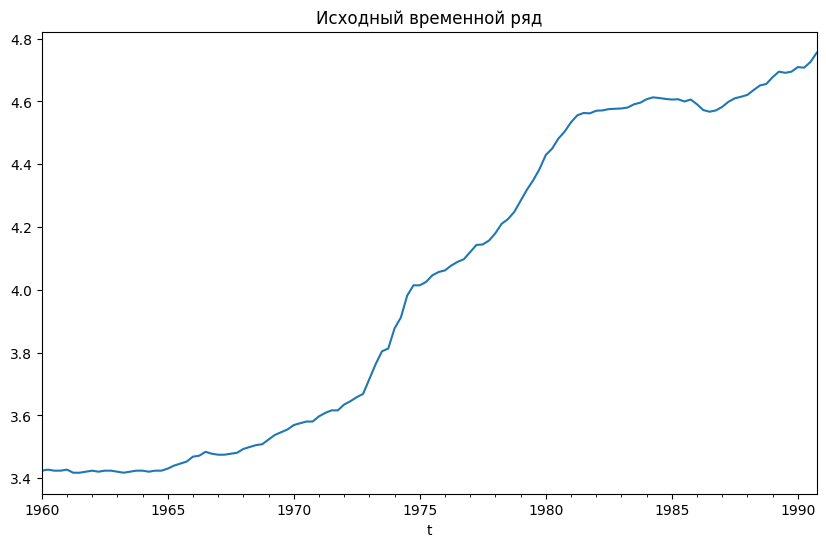

In [7]:
plt.figure(figsize=(10, 6))
ts.plot(title="Исходный временной ряд")
plt.show()

## Сезонная декомпозиция

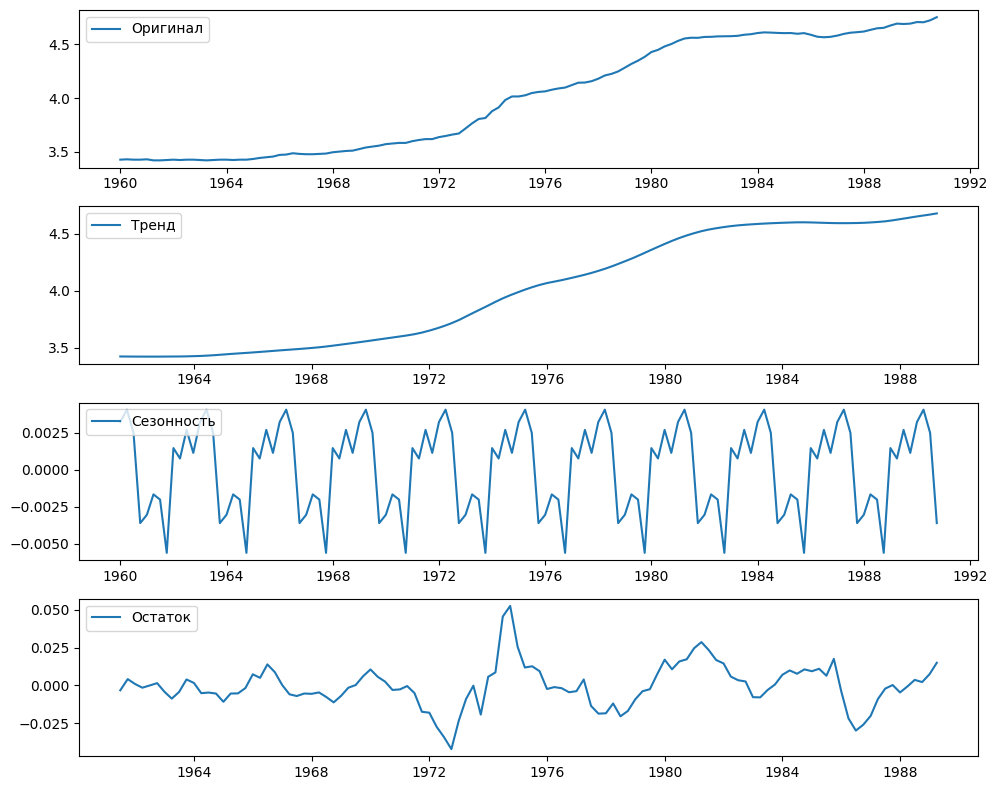

In [8]:
decomposition = seasonal_decompose(ts, model='additive', period=12)

plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(ts, label='Оригинал')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Тренд')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Сезонность')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Остаток')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Анализ ACF/PACF

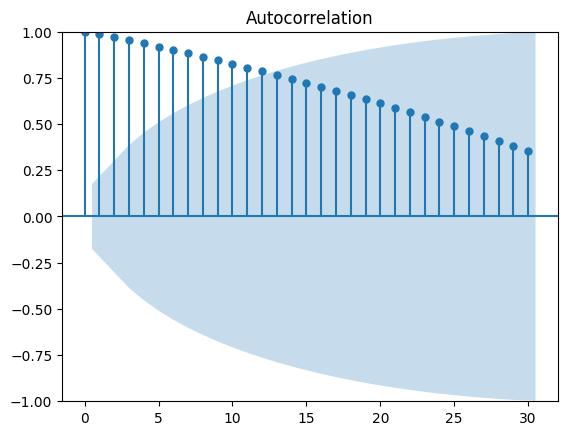

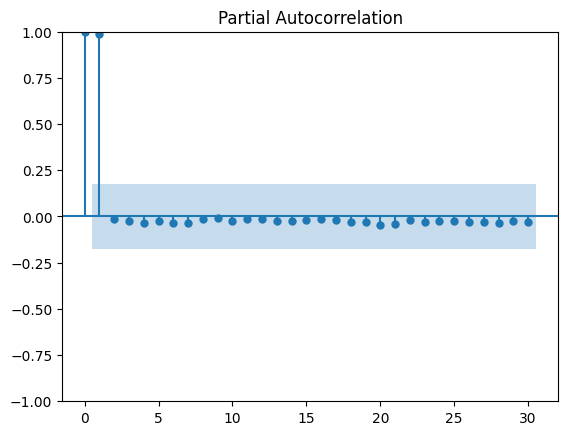

In [9]:
plot_acf(ts.dropna(), lags=30)
plt.show()
plot_pacf(ts.dropna(), lags=30)
plt.show()

## Разделение данных

In [10]:
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

## Построение SARIMA

In [11]:
sarima_model = pm.auto_arima(train, seasonal=True, m=12, stepwise=True, trace=True)
print(sarima_model.summary())

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=-584.963, Time=5.07 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-566.075, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-582.181, Time=1.91 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(0,0,1)[12]             : AIC=-589.133, Time=1.20 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(0,0,0)[12]             : AIC=-591.035, Time=1.04 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(1,0,0)[12]             : AIC=-589.158, Time=0.90 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(1,0,1)[12]             : AIC=-587.152, Time=1.23 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,1)(0,0,0)[12]             : AIC=-589.039, Time=2.72 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,2)(0,0,0)[12]             : AIC=-588.954, Time=2.60 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=-584.162, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,2)(0,0,0)[12]             : AIC=-588.103, Time=1.01 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=-589.038, Time=0.69 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 18.865 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   99
Model:               SARIMAX(0, 2, 1)   Log Likelihood                 297.518
Date:                Fri, 20 Dec 2024   AIC                           -591.035
Time:                        15:57:22   BIC                           -585.886
Sample:                    01-01-1960   HQIC                          -588.953
                         - 07-01-1984                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5619      0.072     -7.794      0.000      -0.7

In [12]:
sarima_fit = SARIMAX(train, order=sarima_model.order, seasonal_order=sarima_model.seasonal_order).fit()

In [13]:
forecast = sarima_fit.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

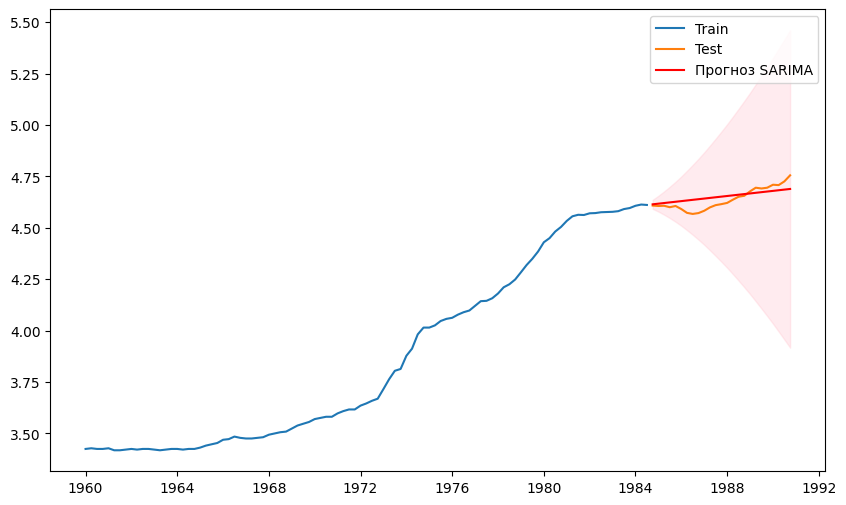

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast_mean, label='Прогноз SARIMA', color='red')
plt.fill_between(forecast_mean.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()

In [15]:
mae_sarima = mean_absolute_error(test, forecast_mean)
mse_sarima = mean_squared_error(test, forecast_mean)
print(f"SARIMA - MAE: {mae_sarima}, MSE: {mse_sarima}")

SARIMA - MAE: 0.03182616323245391, MSE: 0.0013923927305074819


## Модель Хольта-Уинтерса

In [16]:
hw_model = ExponentialSmoothing(train, seasonal='add', trend='add', seasonal_periods=12).fit()
hw_forecast = hw_model.forecast(len(test))

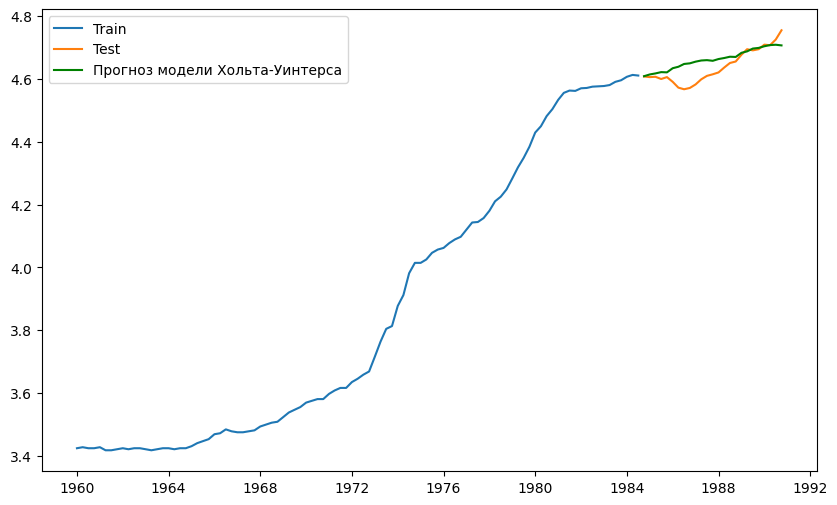

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(hw_forecast, label='Прогноз модели Хольта-Уинтерса', color='green')
plt.legend()
plt.show()

In [18]:
mae_hw = mean_absolute_error(test, hw_forecast)
mse_hw = mean_squared_error(test, hw_forecast)
print(f"Holt-Winters - MAE: {mae_hw}, MSE: {mse_hw}")

Holt-Winters - MAE: 0.030065968816430307, MSE: 0.0015652611134054318


## Сравнение моделей

In [21]:
print("Сравнение моделей:")
print(f"SARIMA - MAE: {mae_sarima}, MSE: {mse_sarima}")
print(f"Holt-Winters - MAE: {mae_hw}, MSE: {mse_hw}")

Сравнение моделей:
SARIMA - MAE: 0.03182616323245391, MSE: 0.0013923927305074819
Holt-Winters - MAE: 0.030065968816430307, MSE: 0.0015652611134054318
